# MI-ADM: second home assignment

  * **Deadline**: 17/04/2018, -2 points for a late submission, hard deadline is the first day of the exam period.
  * **What to submit**: Just this notebook with you code and texts, not the dataset! Please run "Kernel>Restart & Clear Output" before submitting.
  * **How to submit**: Preferred way is to start a repository (for both home assignments) on https://gitlab.fit.cvut.cz and add me as a reporter (not just guest, my username is kloudkar), however, you can send this jupyter notebook by email (*do not send the dataset!!*).

Generally speaking, the goal of this assignment is to use decision trees for the regression problem and experiment with discretisation of continuous (numeric) variables.

What you HAVE TO do:
  * Experiment with the scikit implementation and show how the missing values are treated.
  * Study the data from `house-prices.csv` (see also `house-prices_description.txt`).
  * Try to replace continuous features with some discrete ones (indicator variables, dummy variables, binning, ...) and then run decision tree algorithm on the resulting discrete features to predict the Sales Price.
  * Try to find best possible way of discretisation, tune some reasonably selected hyperparameters (using cross-validation or just a validation set) and measure the results using *Root mean squared logarithmic error (RMSLE)*.

If you do all this properly with some reasonable reults you will be given 4 points out of possible 6.

To get more do some extra work to (try to) improve the result, here are some suggestions:
  * Use also random forest algorithm or gradient boosted trees.
  * Use [XGboost](http://xgboost.readthedocs.io/en/latest/) implementation.
  * Sign up at kaggle.com and apply your resulting model in [the respective competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
%matplotlib inline

data = pd.read_csv('house-prices.csv')
# the logarithm of SalesPrice must be used to evaluate RMSLE properly
# you can comment out the following line and apply the log just before evaluating RMSLE
data.SalePrice = data.SalePrice.apply(math.log) 

# Nahrazení chybějících hodnot
Tyto sloupce obsahují chybějící hodnoty:

In [2]:
for column in data.columns:
    whididntyousaveitjupyter = data[column].isnull().sum()
    if whididntyousaveitjupyter > 0:
        print(column + ': ' + str(whididntyousaveitjupyter))

LotFrontage: 259
Alley: 1369
MasVnrType: 8
MasVnrArea: 8
BsmtQual: 37
BsmtCond: 37
BsmtExposure: 38
BsmtFinType1: 37
BsmtFinType2: 38
Electrical: 1
FireplaceQu: 690
GarageType: 81
GarageYrBlt: 81
GarageFinish: 81
GarageQual: 81
GarageCond: 81
PoolQC: 1453
Fence: 1179
MiscFeature: 1406


In [3]:
data = data.replace(np.nan, '-1')

# Kategorizace

In [4]:
object_columns = data.select_dtypes(['object']).columns

for column in object_columns:
    data[column] = data[column].astype('category')
data[object_columns] = data[object_columns].apply(lambda x: x.cat.codes)

for column in object_columns:
    data[column] = data[column].astype('category')

# Definice testovací funkce

In [5]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

def test_tree(data, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini'):
    dtrain, dtest = train_test_split(data, test_size=0.5, random_state=129)
    X = dtrain.drop(['SalePrice', 'Id'], axis = 1, errors = 'ignore')
    y = dtrain['SalePrice']
    Xtest = dtest.drop(['SalePrice', 'Id'], axis = 1, errors = 'ignore')
    ytest = dtest['SalePrice']
    
    dtree = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split,\
                                        min_samples_leaf=min_samples_leaf, criterion=criterion)
    dtree = dtree.fit(X, y)
    prediction = dtree.predict(Xtest)
    rmsle = np.sqrt(mean_squared_log_error(ytest, prediction))
    print("RMSLE: {:.4}".format(rmsle))

# Binning cílové proměnné
Rozhodl jsem se o equal width binning o 5 binech. (Technicky zde může být cokoli, konkrétní podoba binningu by záležela na zadání.)

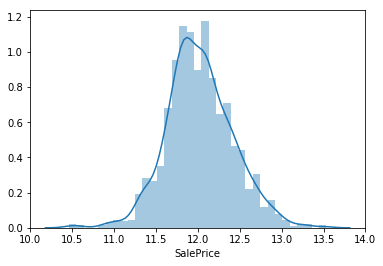

In [6]:
sns.distplot(data['SalePrice'])

In [7]:
number_of_bins = 5
data['SalePrice'] = pd.cut(data['SalePrice'], number_of_bins, labels=False)

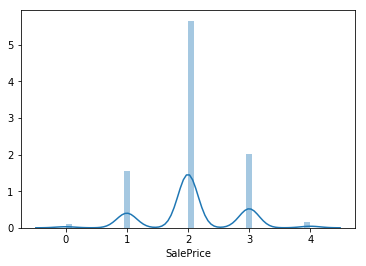

In [8]:
sns.distplot(data['SalePrice'])

In [9]:
test_tree(data)

RMSLE: 0.1951


# Nalezení správných parametrů
(Pomocí X-validace)

In [10]:
from sklearn.model_selection import GridSearchCV

parameters = {'criterion':('gini', 'entropy'), 'max_depth':[1, 3, 5, 8, 10, 15, 20, 50, 100, None],\
              'min_samples_leaf': [1, 2, 3, 5, 10, 20, 25, 50, 100, 200]}
dtrain, dtest = train_test_split(data, test_size=0.5, random_state=129)
X = dtrain.drop(['SalePrice', 'Id'], axis = 1, errors = 'ignore')
y = dtrain['SalePrice']

dtree = tree.DecisionTreeClassifier()
clf = GridSearchCV(dtree, parameters, refit=True)
clf.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 2, 3, 5, 10, 20, 25, 50, 100, 200], 'max_depth': [1, 3, 5, 8, 10, 15, 20, 50, 100, None], 'criterion': ('gini', 'entropy')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
Xtest = dtest.drop(['SalePrice', 'Id'], axis = 1, errors = 'ignore')
ytest = dtest['SalePrice']

clf.best_estimator_.fit(X, y)
prediction = clf.best_estimator_.predict(Xtest)
rmsle = np.sqrt(mean_squared_log_error(ytest, prediction))
print("RMSLE: {:.4}".format(rmsle))

RMSLE: 0.1883


In [12]:
clf.best_estimator_.get_params()

{'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

# Binning ostatních příznaků
## Definice binning funkce

In [13]:
# Splits one column into bins.
# Implementation could be neater - but this works and there is no need to change it
def bin_float(data, column, number_of_bins):
    data = data.sort_values([column])
    number_of_rows = data.shape[0]
    data[column] = list(range(number_of_rows))
    data[column] *= number_of_bins / number_of_rows
    data[column] = data[column].astype(int)
    return data

## Příznaky s více než 15 unikátními hodnotami

In [14]:
for col in dtrain.columns:
    nuni = dtrain[col].nunique()
    if nuni > 20:
        print(col + ': ' + str(nuni))

Id: 730
LotFrontage: 100
LotArea: 582
Neighborhood: 25
YearBuilt: 103
YearRemodAdd: 61
MasVnrArea: 210
BsmtFinSF1: 382
BsmtFinSF2: 79
BsmtUnfSF: 492
TotalBsmtSF: 463
1stFlrSF: 496
2ndFlrSF: 239
GrLivArea: 516
GarageYrBlt: 92
GarageArea: 304
WoodDeckSF: 188
OpenPorchSF: 159
EnclosedPorch: 88
ScreenPorch: 41


## Nalezení správného univerzálního počtu binů
(Pomocí X-validace)

In [15]:
for number_of_bins in [5, 10, 15, 20, 30, 50, 75, 100]:
    dtrain2 = dtrain.copy()
    for col in dtrain2.columns:
        nuni = dtrain2[col].nunique()
        if nuni > 15:
            dtrain2 = bin_float(dtrain, col, number_of_bins)
    X = dtrain2.drop(['SalePrice', 'Id'], axis = 1, errors = 'ignore')
    y = dtrain2['SalePrice']
    
    dtree = tree.DecisionTreeClassifier()
    scores = cross_val_score(dtree, X, y, cv=5)
    print("%d bins - score: %0.4f (+/- %0.4f)" % (number_of_bins, scores.mean(), scores.std() * 2))

5 bins - score: 0.7096 (+/- 0.0301)
10 bins - score: 0.7259 (+/- 0.0496)
15 bins - score: 0.7095 (+/- 0.0667)
20 bins - score: 0.7192 (+/- 0.0198)
30 bins - score: 0.6959 (+/- 0.0673)
50 bins - score: 0.7081 (+/- 0.0714)
75 bins - score: 0.7095 (+/- 0.0614)
100 bins - score: 0.6971 (+/- 0.0394)


## Nalezení správného počtu binů pro jednotlivé příznaky
(Pomocí X-validace)

In [16]:
data2 = data.copy()
for col in dtrain.columns:
    nuni = dtrain[col].nunique()
    if nuni > 20:
        dtrain2 = dtrain.copy()
        max_score = -1
        best_number_of_bins = -1
        for number_of_bins in [5, 10, 15, 20, 30, 50]:
            dtrain2 = bin_float(dtrain, col, number_of_bins)
            X = dtrain2.drop(['SalePrice', 'Id'], axis = 1, errors = 'ignore')
            y = dtrain2['SalePrice']

            dtree = tree.DecisionTreeClassifier()
            scores = cross_val_score(dtree, X, y, cv=5)

            mean_score = scores.mean()
            if mean_score > max_score:
                max_score = mean_score
                best_number_of_bins = number_of_bins
        print("column: %s - best score: %0.4f with %d bins" % (col, max_score, best_number_of_bins))
        data2 = bin_float(data2, col, best_number_of_bins)

column: Id - best score: 0.7409 with 30 bins
column: LotFrontage - best score: 0.7110 with 50 bins
column: LotArea - best score: 0.5846 with 5 bins
column: Neighborhood - best score: 0.6226 with 30 bins
column: YearBuilt - best score: 0.5341 with 10 bins
column: YearRemodAdd - best score: 0.6143 with 5 bins
column: MasVnrArea - best score: 0.5765 with 10 bins
column: BsmtFinSF1 - best score: 0.5677 with 20 bins
column: BsmtFinSF2 - best score: 0.6827 with 20 bins
column: BsmtUnfSF - best score: 0.6507 with 10 bins
column: TotalBsmtSF - best score: 0.5035 with 15 bins
column: 1stFlrSF - best score: 0.5036 with 5 bins
column: 2ndFlrSF - best score: 0.6165 with 30 bins
column: GrLivArea - best score: 0.5024 with 10 bins
column: GarageYrBlt - best score: 0.6274 with 5 bins
column: GarageArea - best score: 0.6018 with 10 bins
column: WoodDeckSF - best score: 0.7204 with 10 bins
column: OpenPorchSF - best score: 0.6294 with 5 bins
column: EnclosedPorch - best score: 0.6981 with 30 bins
colum

In [17]:
test_tree(data, criterion = 'entropy', min_samples_leaf = 20)
test_tree(data2, criterion = 'entropy', min_samples_leaf = 20)

RMSLE: 0.1741
RMSLE: 0.1693


# Dummy variables

In [18]:
data_ext = data.copy()
data_ext['HasGarage'] = data_ext['GarageArea'] > 0
data_ext['HasLot'] = data_ext['LotArea'] > 0
data_ext['HasMasVnr'] = data_ext['MasVnrArea'] != 0
data_ext['HasFireplaces'] = data_ext['Fireplaces'] > 0
data_ext['HasPool'] = data_ext['PoolArea'] > 0
data_ext = data_ext.drop(['Fireplaces', 'GarageArea', 'GarageCars', 'GarageCond', 'PoolArea', 'LotArea'], axis=1)

In [19]:
test_tree(data, criterion = 'entropy', min_samples_leaf = 20)
test_tree(data_ext, criterion = 'entropy', min_samples_leaf = 20)

RMSLE: 0.1741
RMSLE: 0.1715


# Random forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

dtrain, dtest = train_test_split(data, test_size=0.5, random_state=129)
X = dtrain.drop(['SalePrice', 'Id'], axis = 1, errors = 'ignore')
y = dtrain['SalePrice']
Xtest = dtest.drop(['SalePrice', 'Id'], axis = 1, errors = 'ignore')
ytest = dtest['SalePrice']
    
rf = RandomForestClassifier(max_depth=10, random_state=444)
rf = rf.fit(X, y)
prediction = rf.predict(Xtest)
rmsle = np.sqrt(mean_squared_log_error(ytest, prediction))
print("RMSLE: {:.4}".format(rmsle))

RMSLE: 0.1673


## Nalezení správných parametrů

In [21]:
parameters = {'criterion':('gini', 'entropy'), 'max_depth':[1, 3, 5, 8, 10, 15, 20, 50, 100, None],\
              'min_samples_leaf': [1, 2, 3, 5, 10, 20, 25, 50, 100, 200]}
dtrain, dtest = train_test_split(data, test_size=0.5, random_state=129)

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, refit=True)
clf.fit(X, y)

clf.best_estimator_.fit(X, y)
prediction = clf.best_estimator_.predict(Xtest)
rmsle = np.sqrt(mean_squared_log_error(ytest, prediction))
print("RMSLE: {:.4}".format(rmsle))

RMSLE: 0.1652


# Gradient descent boosted trees

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

rf = GradientBoostingClassifier(max_depth=5, random_state=444)
rf = rf.fit(X, y)
prediction = rf.predict(Xtest)
rmsle = np.sqrt(mean_squared_log_error(ytest, prediction))
print("RMSLE: {:.4}".format(rmsle))

RMSLE: 0.1609


# Závěr
Rozhodovací stromy dokáží vcelku dobře klasifikovat nemovitosti do kategorií podle jejich ceny.

Změnou parametrů modelu se podařilo chybu mírně snížit z 0.19 na zhruba 0.17. Testovanými parametry byly: maximální hloubka, minimální počet vzroků v listu a maximalizované kritérium -- GINI/entropie (volba entropie místo GINI měla asi největší, byť stále velmi malý vliv).

Dále jsem prováděl úpravu dat - binning příznaků s příliš mnoha unikátními hodnotami (velmi malý pozitivní vliv) a tvorb dummy variables (žádný vliv).

Celkem úspěšným přístupem bylo použití ensemblu (lesa) místo samostatných stromů. Ani zde však příliš nepomohlo experimentovat s parametry.

Poslední model - Gradient descent boosted trees - jsem ani s různými hodnotami nastavení netestoval, protože výpočet trval příliš dlouho a pravděpodobně by nic nového nepřinesl.